# BPSolver

### Imports and utility functions

In [1]:
import glob
from datetime import datetime, timedelta
from tqdm import tqdm

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from grids import Grid, draw_grid
from queens import Queens
from tango import Tango
from BPSolver import BPSolver

In [2]:

def imshow(images, col_qty=5, figsize=(10, 15), axis_off=True):
    """"
    images: [(title1, image1), (title2, image2), (title3, image3), ... ]
    col_qty: number of columns in the grid of images to show
    figsize: sisze of each image
    """
    img_count = len(images)

    row_qty= (img_count // col_qty) + (img_count % col_qty > 0)

    fig, axes = plt.subplots(row_qty, col_qty, figsize=figsize)

    axes = np.array(axes).flatten()  # access the array with just one index

    for i, (title, img) in enumerate(images):
        if len(img.shape) == 3:  # Color image (BGR)
            axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:  # Gray image
            axes[i].imshow(img, cmap = "gray")

        axes[i].set_title(title)
        if axis_off:
            axes[i].axis("off")

    # Hide remaining axes
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


In [3]:
def imshow_1(title, image, figsize=(10, 5)):
    
    fig, ax = plt.subplots(figsize=figsize)

    if len(image.shape) == 3:  # Imagen en color (BGR)
        ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else:  # Imagen en escala de grises
        ax.imshow(image, cmap = "gray")
    
    ax.set_title(title)
    # axes[0].axis("off")

    plt.tight_layout()
    plt.show()


In [4]:
def imshow_2(tit1, img1, tit2, img2, figsize=(10, 5)):
    # Mostrar dos imagenes
    fig, axes = plt.subplots(1, 2, figsize=figsize)  # 1 fila, 2 columnas

    if len(img1.shape) == 3:  # Imagen en color (BGR)
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        cmap1 = None
    else:
        cmap1 = 'gray'

    if len(img2.shape) == 3:  # Imagen en color (BGR)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        cmap2 = None
    else:
        cmap2 = 'gray'

    # Imagen 1
    axes[0].imshow(img1, cmap=cmap1)
    axes[0].set_title(tit1)
    # axes[0].axis("off")

    # Imagen procesada
    axes[1].imshow(img2, cmap=cmap2)
    axes[1].set_title(tit2)
    # axes[1].axis("off")

    plt.tight_layout()
    plt.show()

In [5]:
def update_pbar(pbar, start_time, done, total, results):
    pbar.update(1)
    elapsed_time = datetime.now() - start_time
    estimated_total = (elapsed_time / done) * total
    remaining_time = estimated_total - elapsed_time
    finish_time = datetime.now() + remaining_time
    pbar.set_postfix(ETA=finish_time.strftime("%H:%M:%S"), Status=results)

### Image processing

#### Pre-process

In [21]:
# Load image

# gr = Grid(image_path='./img/5663-9519.PNG')
# gr = Grid(image_path='./img/00-IMG_9563.PNG')
# gr = Grid(image_path='./img/2317-12-14.57.47-julio.jpeg')
# gr = Grid(image_path='./img/03-white-01.jpeg')
# gr = Grid(image_path='./img/03-white-02.jpeg')
gr = Grid(image_path='./img/03-white-03.jpeg')


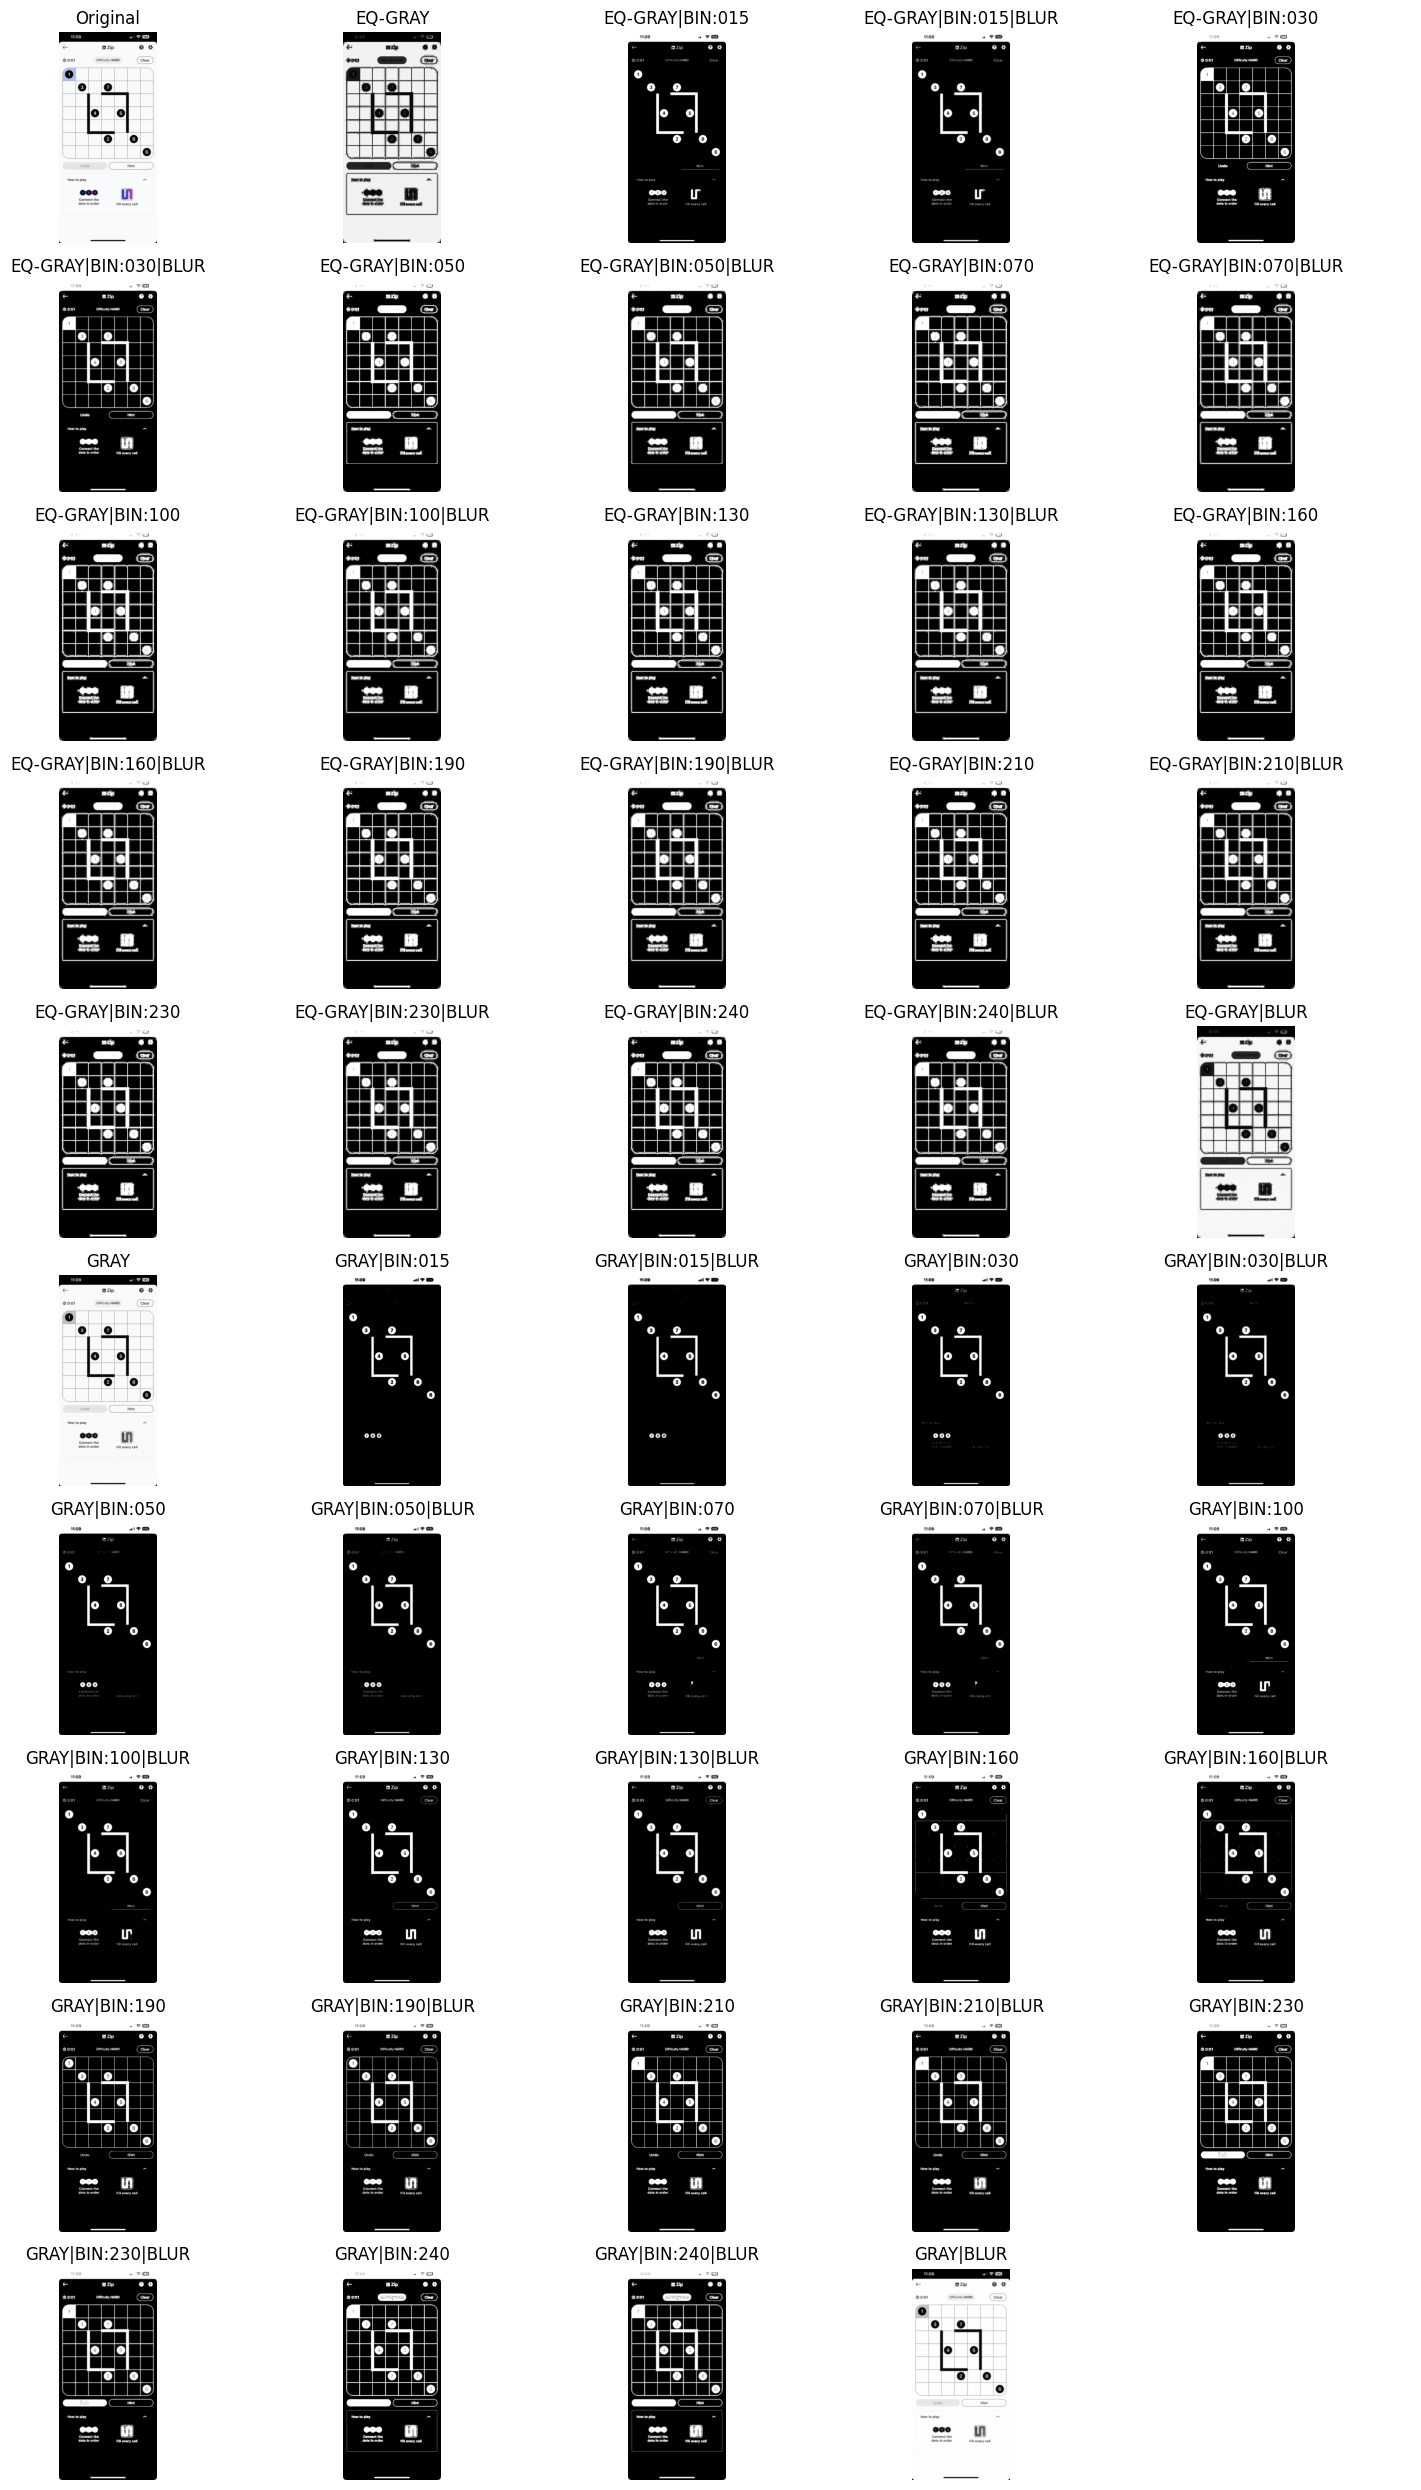

In [22]:
# Show original and pre-processed images
gr.preprocess_image(resize_width=500)
images = [("Original", gr.image)] + sorted(gr.work_imgs.items())
imshow(images, col_qty=5, figsize=(15, 25))

#### Finding the board's grid

In [23]:
# Find the grid (show the process)

output = gr.find_grid(
    min_line_length = 300, 
    max_line_gap = 8, 
    max_groupping_dist = 3, 
    min_valid_n=5,
    max_valid_n=15,
    show_process=True
)

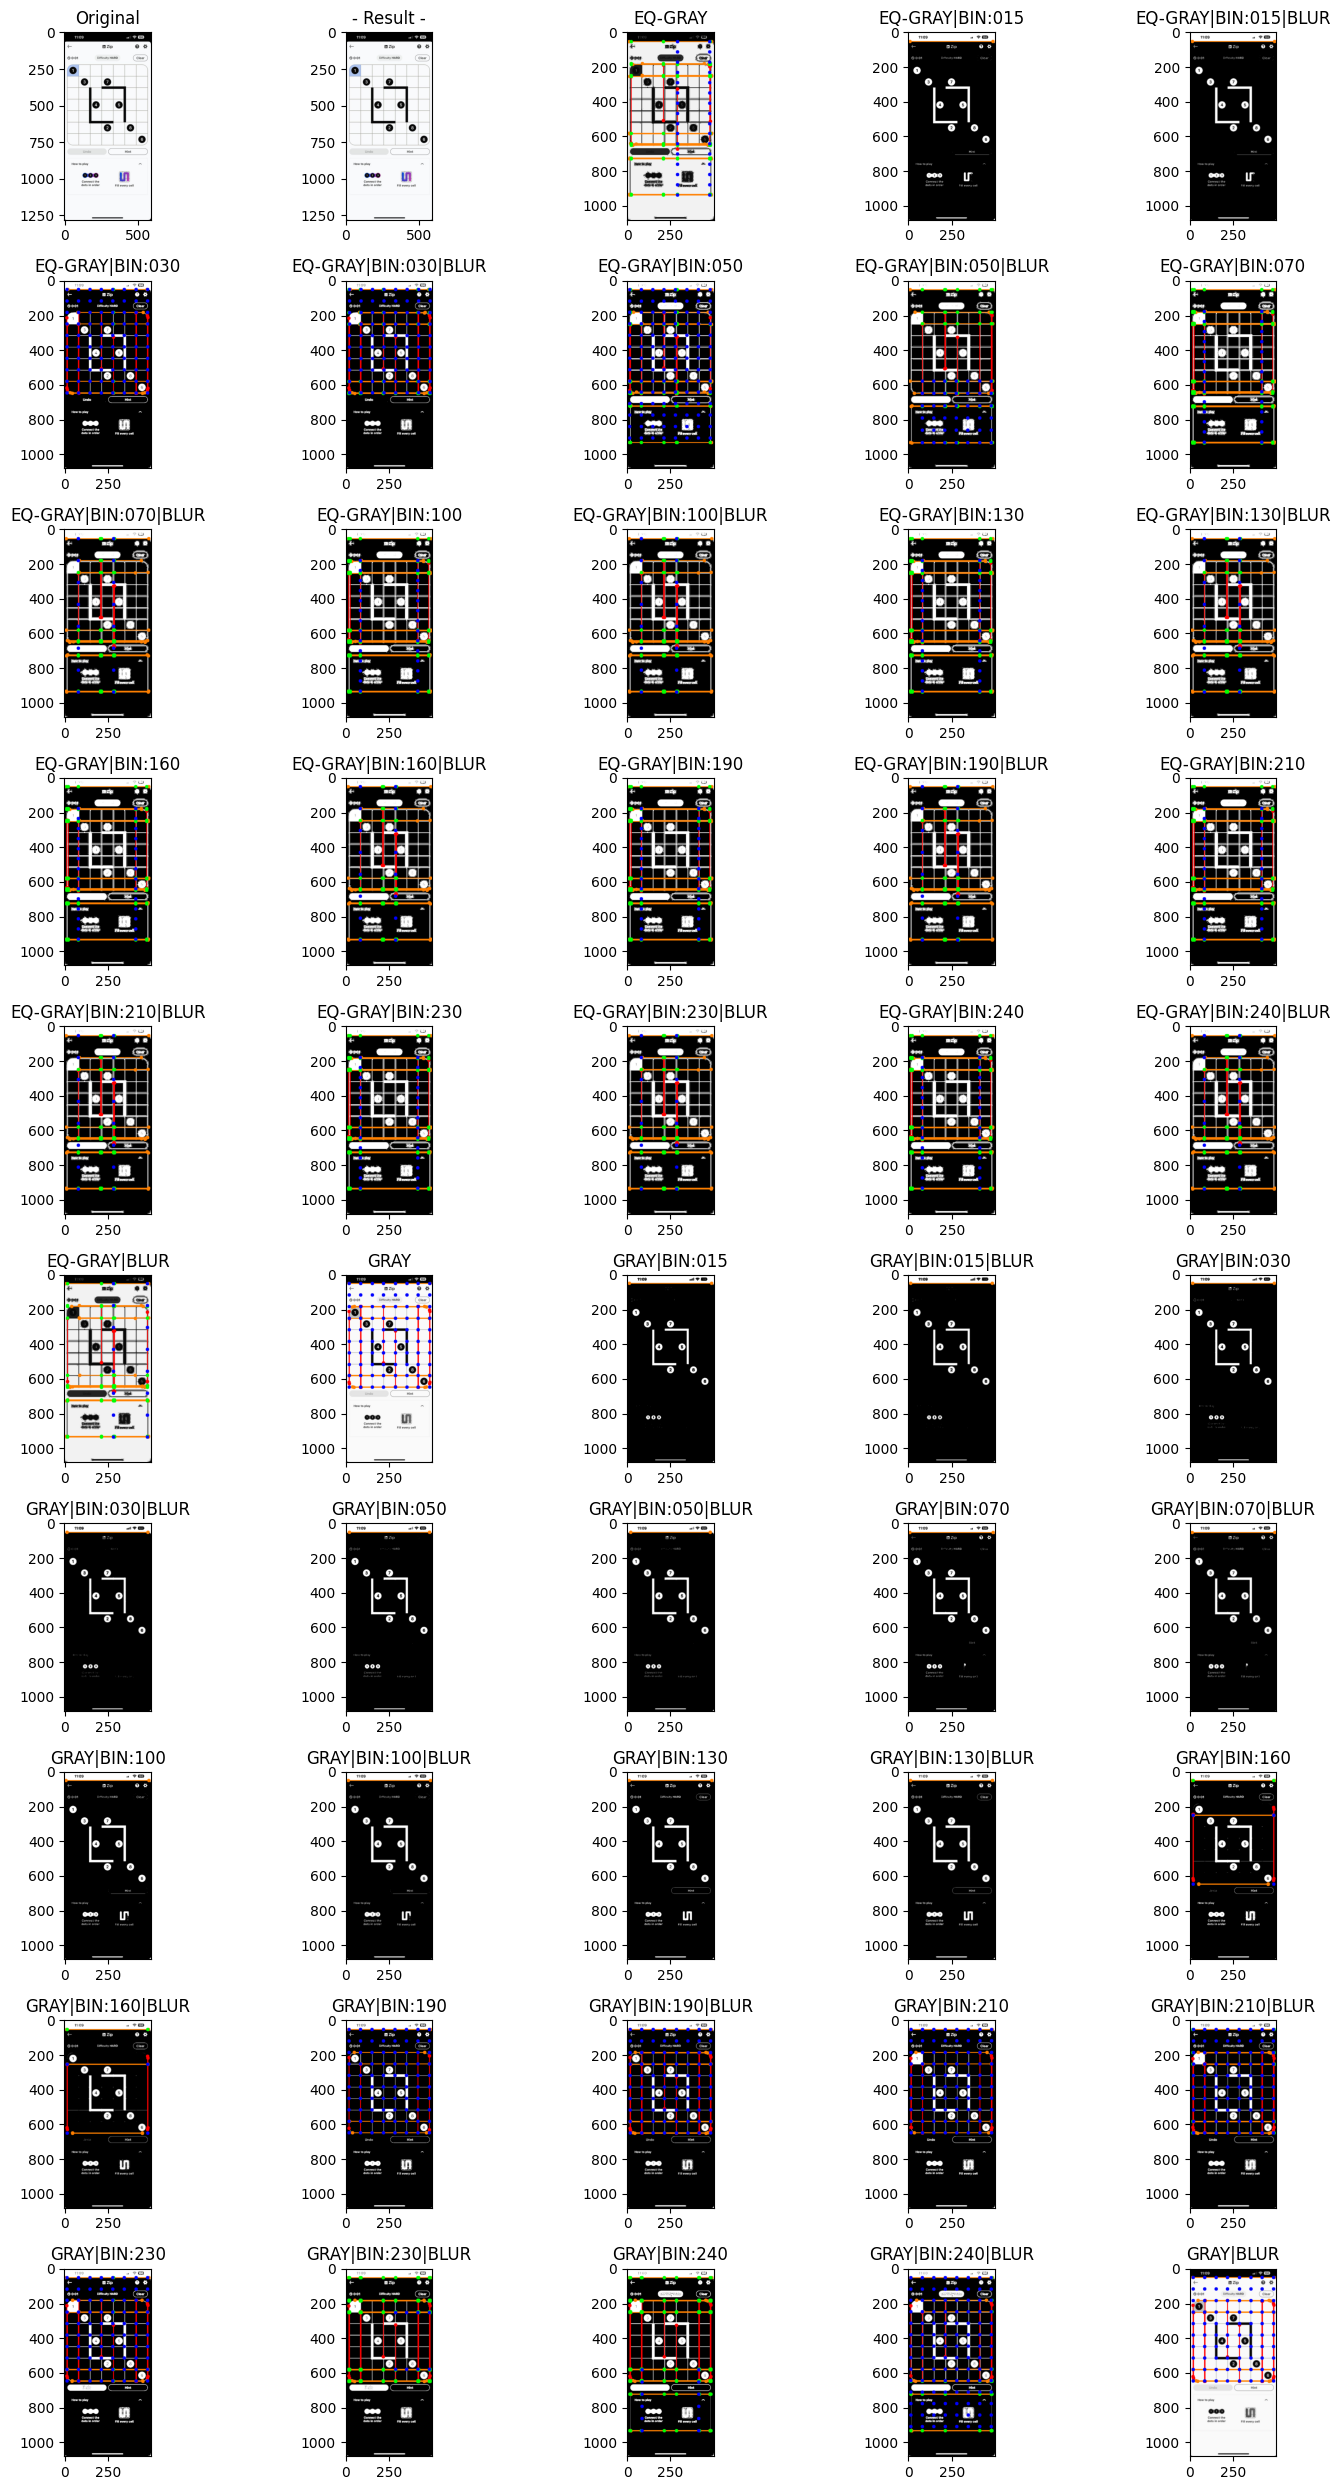

In [24]:
# Show the results for each pre-process

images = [("Original", gr.image)] + sorted(output.items())
imshow(images, axis_off=False, figsize=(15, 25))

In [ ]:
# Process a bunch of images and analyze the Grid class parameters that have more chance to find the grid

threshold_values = [70, 100, 130, 160]
min_line_length = [300, 350, 400]
max_line_gap = [8, 12]
max_groupping_dist = 3

columns = [
    'filename', 'best_n', 'best_label', 'max_cluster_size', 
    'pre-proc', 'in_final_set', 'label', 'n', 'height', 'width',
    'min_line_length', 'max_line_gap', 'max_groupping_dist', 'cluster_size'
]
grids = pd.DataFrame(columns=columns)
show = []
results = ''
filenames = sorted(glob.glob('./img/*.*'))
start_time, done = datetime.now(), 0
with tqdm(total=len(filenames), desc="Progress", unit="iter") as pbar:
    for filename in filenames:
        gr = Grid(filename)
        gr.preprocess_image(resize_width=500, threshold_values=threshold_values)
        gr.find_grid(
            min_line_length=min_line_length, 
            max_line_gap=max_line_gap,
            max_groupping_dist=max_groupping_dist,
            min_valid_n=6, max_valid_n=16
        )
        if gr.n:
            df = pd.DataFrame(gr.all_grids)
        else:
            df = pd.DataFrame([{
                    'pre-proc': '', 
                    'in_final_set': False, 
                    'label': 0, 
                    'n': 0, 
                    'height': 0,
                    'width': 0,
                    'min_line_length': 0, 
                    'max_line_gap': 0, 
                    'max_groupping_dist': 0, 
                    'cluster_size': 0
            }])
        df['filename'] = gr.image_path.replace('./img/', '', 1)
        df['best_n'] = gr.n if gr.n else 0
        df['best_label'] = gr.best_label if gr.best_label else 0
        df['max_cluster_size'] = gr.max_cluster_size if gr.max_cluster_size else 0
        show.append((
                f"n: {gr.n}-label: {gr.best_label}\n{gr.image_path.replace('./img/', '', 1)}",
                draw_grid(gr.image, gr.x_axis, gr.y_axis)
        ))
        for c in set(columns) - set(df.columns):
            df[c] = None
        df = df[columns]
        grids = pd.concat([grids, df]).reset_index(drop=True)
        results += "✔" if gr.n > 0 else "✖"
        done += 1
        update_pbar(pbar, start_time, done, len(filenames), results)
        

In [ ]:
grids        

In [ ]:
# For which files could a valid grid not be found?

not_solved = grids[grids['best_n']==0]['filename'].to_list()
solved = grids[grids['best_n']!=0]['filename'].unique()
not_solved, len(not_solved), len(solved)

In [ ]:
# Make a list of parameters with the files that each of them managed to resolve

param_cols = ['pre-proc', 'min_line_length', 'max_line_gap', 'max_groupping_dist']
grids['in_final_set'] = grids['in_final_set'].fillna(False).astype(bool)
params = grids[grids['in_final_set']].groupby(param_cols)[param_cols+['filename']].apply(lambda grp: set(grp['filename'].unique()))
params = params.rename('filenames').reset_index()
params['qty'] = params['filenames'].apply(len)
params = params.sort_values(by='qty', ascending=False)
params

In [ ]:
# Find out which parameters provided more solutions

filenames = set()
for i in range(len(params)):
    p = params.iloc[i]
    filenames = filenames | p['filenames']
    print(', '.join(f"{col}: {p[col]}" for col in param_cols), f"covered: {len(filenames)}")
    if len(filenames) == len(solved):
        break


In [ ]:
# Show all the grids found

for i in range(0, len(show), 20):
    imshow(show[i:i+20], col_qty=5, axis_off=False, figsize=(15, 25))

### Solving a puzzle

In [ ]:
threshold_values = [70, 100, 130, 160]
min_line_length = [300, 350, 400]
max_line_gap = [8, 12]
max_groupping_dist = 3

# Create a BoardPuzzle object

# grid = Grid('./img/9560-9629.PNG')
# grid = Grid('./img/7508-0068-1.png')
# grid = Grid('./img/00-IMG_9563.PNG')
# grid = Grid('./img/5786-9624.PNG')
# grid = Grid('./img/7912-08-17.48.12.jpeg')
grid = Grid('./img/2317-12-14.57.47-julio.jpeg')  # TODO: ver de agregar algun thesshold, muy claritas las lineas !!!!
# grid = Grid('./img/2452-12-13.20.42-julio.jpeg')  # TODO: ver de agregar algun thesshold, muy claritas las lineas !!!!
# grid = Grid('./img/7724-0240-4cde.JPG')
# grid = Grid('./img/9070-23-13-45-23.jpg')
# grid = Grid('./img/02-filterIMG_9563.jpg')
# grid = Grid('./img/02-scribble-IMG_9563.jpg')

# grid = Grid('./img/xxxxxxxxaaaaaaaaaaaaa63.PNG')
solved = False
if not solved and grid.image is not None:
    print('Trying to find a Queens puzzle')
    puzzle = Queens(
        grid, 
        resize_width=500, 
        threshold_value= threshold_values,
        min_line_length= min_line_length, 
        max_line_gap= max_line_gap,
        max_groupping_dist= max_groupping_dist,
        min_valid_n= 6, max_valid_n= 16
    )
    print(puzzle.msg)
    solver = BPSolver(puzzle, 1000, timedelta(seconds=120), 20)
    msg = solver.solve()
    print(msg)
    solved = solver.solved
if not solved and grid.image is not None:
    print('Trying to find a Tango puzzle')
    puzzle = Tango(
        grid, 
        resize_width=500, 
        threshold_value= threshold_values,
        min_line_length= min_line_length, 
        max_line_gap= max_line_gap,
        max_groupping_dist= max_groupping_dist,
        eq_filename= 'templates_eq.png',
        x_filename='templates_x.png'
    )
    print(puzzle.msg)
    solver = BPSolver(puzzle, 1000, timedelta(seconds=120), 20)
    msg = solver.solve()
    print(msg)
    solved = solver.solved

if grid.image is not None:
    imshow(
        [
            ('original', grid.image),
            ('grid', draw_grid(grid.image, grid.x_axis, grid.y_axis)),
            ('result', puzzle.draw_solution(grid.image))
        ],
        axis_off=False,
        figsize=(25, 10)
    )

### Solve all the puzzles

In [ ]:
# Solve the puzzles

threshold_values = [70, 100, 130, 160]
min_line_length = [300, 350, 400]
max_line_gap = [8, 12]
max_groupping_dist = 3

show = []
results = ''
failed = []
filenames = sorted(glob.glob('./img/*.*'))
tango_symbol_templates = Tango.load_templates_from_files('templates_eq.png', 'templates_x.png')

start_time, done = datetime.now(), 0
with tqdm(total=len(filenames), desc="Progress", unit="iter") as pbar:
    for filename in filenames:
        # Try to find a Grid
        grid = Grid(filename)
        grid.preprocess_image(resize_width=500, threshold_values=threshold_values)
        grid.find_grid(
            min_line_length=min_line_length, 
            max_line_gap=max_line_gap,
            max_groupping_dist=max_groupping_dist,
            min_valid_n=6, max_valid_n=16
        )
        if grid.n == 0:
            failed.append({'filename': filename, 'fail': 'No grid detected'})
            results += "✖"
            done += 1
            update_pbar(pbar, start_time, done, len(filenames), results)
            continue

        solved = False

        if not solved:
            # Try to find a "Queens" board in the image
            puzzle = Queens(grid)
            if puzzle.board is not None:  # if found a puzzle, try to solve it
                solver = BPSolver(puzzle, 1000, timedelta(seconds=120), 20)
                msg = solver.solve()
                solved = solver.solved
        
        if not solved:
            # Try to find a "Tango" board in the image
            puzzle = Tango(grid, constraint_templates=tango_symbol_templates)
            if puzzle.board is not None:  # if found a puzzle, try to solve it
                solver = BPSolver(puzzle, 1000, timedelta(seconds=120), 20)
                msg = solver.solve()
                solved = solver.solved
        
        if solved:
            show.append((
                f"{grid.image_path.replace('./img/', '', 1)}",
                puzzle.draw_solution()
            ))
            results += "✔"
        else:
            show.append((
                f"{grid.image_path.replace('./img/', '', 1)}\nFAILED",
                puzzle.draw_solution(grid.image)
            ))
            results += "✖"
            # add it to the failed list
            failed.append({'filename': filename, 'fail': msg})

        # update progress bar
        done += 1
        update_pbar(pbar, start_time, done, len(filenames), results)
        

In [ ]:
# Show all the results found

for i in range(0, len(show), 20):
    imshow(show[i:i+20], col_qty=5, axis_off=False, figsize=(15, 25))

In [ ]:
failed = pd.DataFrame(failed)
failed.sort_values(by='fail')